## Instructions
I am tasked with predicting temperature for weather in Szeged, Hungary area, taken from this [Kaggle dataset](https://www.kaggle.com/budincsevity/szeged-weather/home) and checking if my model meets the Gauss-Markov Conditions.  

### 1 - Load and View the Data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
f

In [2]:
weather_df = pd.read_csv('weatherinszeged.csv')

Looking at the weather dataset, it seems that most features are continuous variables with some object variables.  Only one feature (preciptype) has missing values, and only the temperature related features go below 0.  I will need a visual or test to double check, but it appears most of the numerical features are not normally distributed.  

In [3]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null object
summary                96453 non-null object
preciptype             95936 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


### 2 - Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

#### 2.1 - Visualizing the Target
Temperature looks like it has a nearly normal distribution (maybe a slight left skew) but with a flatter top.  Its difficult to tell where the peak is, as it seems to range over 5-15 degrees C.  

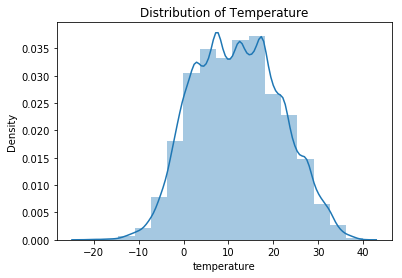

In [6]:
sns.distplot(weather_df['temperature'], bins = 17)
plt.title('Distribution of Temperature')
plt.ylabel('Density')

#### 2.2 - Relationship Between Features and Target Variable
There are four features to focus on: humidity, wind speed, wind bearing, and pressure.  Below are the relationships of each feature and temperature.  From the plots, it appears that humidity and temperature have an inverse relationship, wind speed and wind bearing have little relationship with temperature, and something looks very wrong with the pressure plot.  

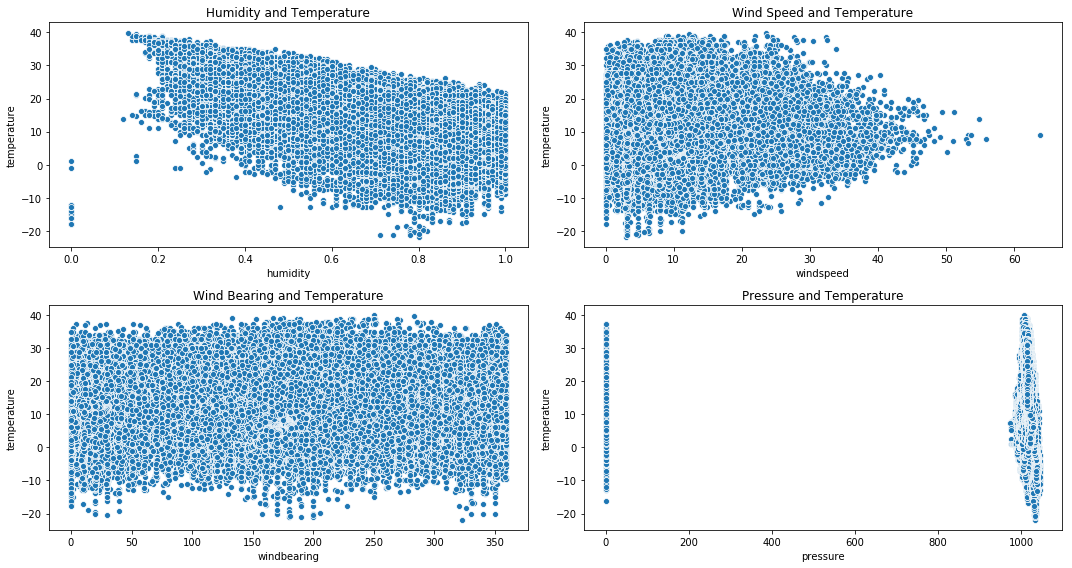

In [7]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(15,8))

sns.scatterplot(x = 'humidity', y = 'temperature', data = weather_df, ax = axis1)
sns.scatterplot(x = 'windspeed', y = 'temperature', data = weather_df, ax = axis2)
sns.scatterplot(x = 'windbearing', y = 'temperature', data = weather_df, ax = axis3)
sns.scatterplot(x = 'pressure', y = 'temperature', data = weather_df, ax = axis4)

axis1.set_title('Humidity and Temperature')
axis2.set_title('Wind Speed and Temperature')
axis3.set_title('Wind Bearing and Temperature')
axis4.set_title('Pressure and Temperature')

plt.tight_layout()

Looking at the distribution of pressure, it seems most of the pressure are centered at 1000 mbar, but there are a few at 0 mbar.  Having 0 mbar is only really possible at high elevations (in the atmosphere), and the elevation of Szeged is ~250 feet.  As such, these measurements of 0 mbar are completely erroneous and will be removed from the dataset, as they represent ~1% of the total data.  

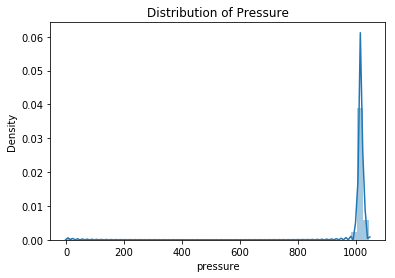

In [8]:
sns.distplot(weather_df['pressure'])
plt.title('Distribution of Pressure')
plt.ylabel('Density')

In [9]:
print('The percent of erroneous pressure is: {}'.format(weather_df[weather_df['pressure']==0].shape[0]/weather_df.shape[0]*100))

The percent of erroneous pressure is: 1.3353654111328834


In [10]:
weather_df = weather_df[weather_df['pressure'] > 0]

Below are the distribution of pressure and relationship between pressure and temperature after the 0 mbar data points have been removed.  Pressure has a slightly left skewed distribution with a peak at 1015 mbar, and there appears to be a slight inverse relationship between pressure and temperature.  

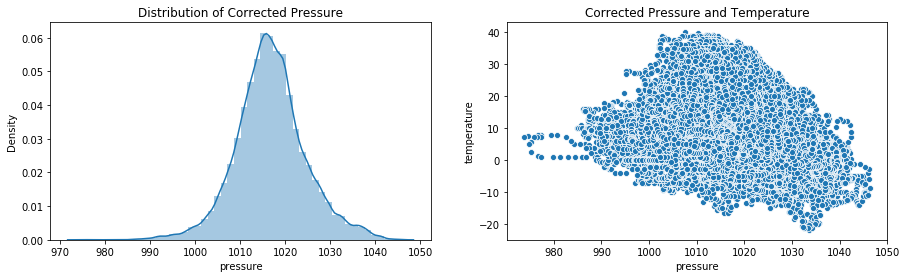

In [11]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

sns.distplot(weather_df['pressure'], ax = axis1)
sns.scatterplot(x = 'pressure', y = 'temperature', data = weather_df, ax = axis2)

axis1.set_title('Distribution of Corrected Pressure')
axis2.set_title('Corrected Pressure and Temperature')

axis1.set_ylabel('Density')

A closer look at humidity also shows some data points have 0 humidity.  This is also impossible.  Since there are 22 of these rows, I will also remove them.  

In [12]:
weather_df = weather_df[weather_df['humidity']!=0]

#### 2.3 - Correlations
The correlation matrix below shows that temperature is most correlated with humidity, and loosely correlated with pressure.  The features are not correlated with each other.  

In [13]:
weather_col =['humidity', 'windspeed', 'windbearing', 'pressure']

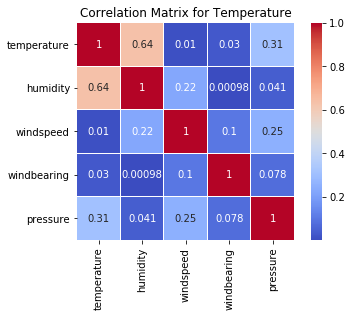

In [14]:
sns.heatmap(np.absolute(pd.concat([weather_df['temperature'], weather_df[weather_col]], axis = 1).corr()), square = True, 
           annot = True, linewidth = 0.1, cmap = 'coolwarm')
plt.title('Correlation Matrix for Temperature')

#### 2.4 - The Model!
At this point, I am ready to estimate the model with OLS.  Its R-squared value is 0.533.  This seems pretty low to me. Perhaps I should look at Gauss Markov Conditions?

In [15]:
weatherY = weather_df['temperature']
weatherX = weather_df[weather_col]
weather_lrm = linear_model.LinearRegression()
weather_lrm.fit(weatherX, weatherY)
print('\nCoefficients: \n', weather_lrm.coef_)
print('\nIntercept: \n', weather_lrm.intercept_)


Coefficients: 
 [ -3.29588836e+01  -3.18926097e-01   2.47829801e-03  -4.15538916e-01]

Intercept: 
 461.684072666


### 3 - Gauss Markov Conditions

#### 3.1 - Linearity of the Model in its Coefficients
This means that the target variable should be linear with its features.  Section 2.2 plots the temperature with each feature, showing a linear relationship.  **The requirements for this assumption is met.**

#### 3.2 - The Error Term Should be Zero On Average
The error term can be found by subtracting the predicted Y values from the true Y values.  When this is done to the weather dataset, the mean error becomes 1 e-14, which is pretty close to zero.  **The requirements for this assumption are met.**

In [40]:
weather_pred = weather_lrm.predict(weatherX)
weather_errors = weatherY - weather_pred

In [42]:
print('Mean of errors in temperature is {}.'.format(np.mean(weather_errors)))

Mean of errors in temperature is 1.0705003713286766e-14.


#### 3.3 - Homoscedasticity
The errors should be consistent for all predicted values.  In the plot below, if the model were homoscedastic, then the points should be evenly distributed above and below x = 0 (orange horizontal line) over the whole x range.  Instead, there are more residuals above the line when x < 0, and more residuals under the line when x > 0.  It appears that the model is heteroscedastic.  

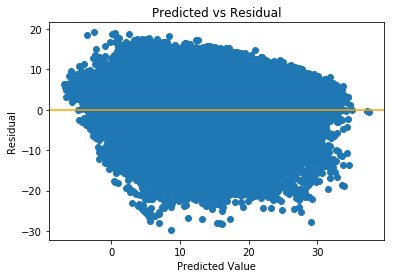

In [48]:
plt.scatter(weather_pred, weather_errors)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.axhline(y = 0, color = 'orange')
plt.title('Predicted vs Residual')

A more mathematical way to find out if this model is hetero or homoscedastic is to use the Bartlett and Levene tests.  For both tests, the null hypothesis is that the model is homoscedastic.  For the weather model, both tests have p-values under 0.05, so the null hypothesis is rejected and the model is heteroscedastic. **The requirements for the assumption are not met.**  This means the model could be consistently over or under predicting the true value.  

In [50]:
weather_bartlett = bartlett(weather_pred, weather_errors)
weather_levene = levene(weather_pred, weather_errors)

In [75]:
print('The Bartlett test value is {0:3g} with a p-value of {1:.3g}.'.format(weather_bartlett[0], weather_bartlett[1]))
print('The Levene test value is {0:3g} with a p-value of {1:.3g}.'.format(weather_levene[0], weather_levene[1]))

The Bartlett test value is 418.023 with a p-value of 6.57e-93.
The Levene test value is 290.982 with a p-value of 3.4e-65.


#### 3.4 - Low Multicollinearity
This can be verified with a correlation matrix, such as the one in section 2.3.  None of the features are strongly correlated with each other. **The requirements for this assumption are met.**

#### 3.5 - Error Terms Should be Uncorrelated
One way to find out if error terms are correlated are not is to use statsmodel autocorrelation function.  The plot below shows that the autocorrelation of error is pretty high, ranging from 0.65 to 0.95.  **The requirements of this assumption are not met.** 

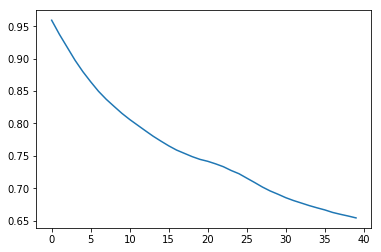

In [78]:
weather_acf= acf(weather_errors)
plt.plot(weather_acf[1:])

#### 3.6 - Features Shouldn't be Correlated with the Errors
Again, a correlation matrix between the features and errors can tell us if anything is correlated with each other.  It looks like nothing is very correlated, thus **the requirements of this assumption are met.**

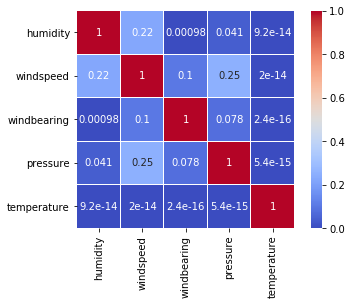

In [92]:
sns.heatmap(np.absolute(pd.concat([weather_df[weather_col], weather_errors], axis = 1).corr()), square = True,
           annot = True, linewidth = 0.1, cmap = 'coolwarm')
plt.title('Correlation Matrix with Error')